In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch 
from torch import nn
from torch.utils.data import DataLoader, Dataset, TensorDataset, SequentialSampler
import tqdm
from transformers import BertForSequenceClassification, AdamW, RobertaTokenizer, RobertaModel
from sklearn.preprocessing import LabelEncoder

In [2]:
train = pd.read_csv('train_1k.csv', index_col = 0)
val = pd.read_csv('val_1k.csv', index_col = 0)
test = pd.read_csv('test_1k.csv', index_col = 0)

train.dropna(subset = ['ICD9_CODE_1k'], inplace = True)
val.dropna(subset = ['ICD9_CODE_1k'], inplace = True)
test.dropna(subset = ['ICD9_CODE_1k'], inplace = True)

In [3]:
# Get all labels

label_list = []
for code in train['ICD9_CODE_1k']:
    labels = code.split(',')
    label_list.extend([label for label in labels if label not in label_list])

In [4]:
label_dict = {}
for i, label in enumerate(label_list):
    label_dict[label] = i

In [8]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case = True)

In [9]:
roberta = RobertaModel.from_pretrained('roberta-base', output_attentions=True)

In [15]:
# Split the sequence in half and then tokenize seperately

def roberta_tokenize(data, max_length, label_dict):
    
    input_ids_first = []
    input_ids_second = []
    attention_masks_first = []
    attention_masks_second = []
    labels = []
    
    for sentence in data['TEXT']:
        text_len = len(sentence)

        encoded_dict_first = tokenizer.encode_plus(sentence[:text_len//2], add_special_tokens = True, max_length = max_length,\
                                             pad_to_max_length = True, return_attention_mask = True, return_tensors = 'pt')
        input_ids_first.append(encoded_dict_first['input_ids'])
        attention_masks_first.append(encoded_dict_first['attention_mask'])
   
        
        encoded_dict_second = tokenizer.encode_plus(sentence[text_len//2:], add_special_tokens = True, max_length = max_length,\
                                             pad_to_max_length = True, return_attention_mask = True, return_tensors = 'pt')
        input_ids_second.append(encoded_dict_second['input_ids'])
        attention_masks_second.append(encoded_dict_second['attention_mask'])
        
    for codes in data['ICD9_CODE_1k']:
        label = [0]*1000
        
        all_code = codes.split(',')
        for code in all_code:
            label[label_dict[code]] = 1
        
        labels.append(torch.tensor(label))


        
    input_ids_first = torch.cat(input_ids_first, dim=0)
    attention_masks_first = torch.cat(attention_masks_first, dim=0)
    input_ids_second = torch.cat(input_ids_second, dim=0)
    attention_masks_second = torch.cat(attention_masks_second, dim=0)
    labels = torch.stack(labels, dim=0)
        
    return input_ids_first, attention_masks_first, input_ids_second, attention_masks_second, labels

In [16]:
batch_size = 4

input_ids_first_train, attention_masks_first_train, input_ids_second_train,\
attention_masks_second_train, labels_train = roberta_tokenize(train, 512, label_dict)

train_dataset_roberta = TensorDataset(input_ids_first_train, attention_masks_first_train, input_ids_second_train,\
                                   attention_masks_second_train, labels_train)
train_loader_roberta = DataLoader(train_dataset_roberta, shuffle = True, batch_size = batch_size)

input_ids_first_val, attention_masks_first_val, input_ids_second_val,\
attention_masks_second_val, labels_val = roberta_tokenize(val, 512, label_dict)

val_dataset_roberta = TensorDataset(input_ids_first_val, attention_masks_first_val, input_ids_second_val,\
                                 attention_masks_second_val, labels_val)
val_loader_roberta = DataLoader(val_dataset_roberta, shuffle = True, batch_size = batch_size)

input_ids_first_test, attention_masks_first_test, input_ids_second_test,\
attention_masks_second_test, labels_test = roberta_tokenize(test, 512, label_dict)

test_dataset_roberta = TensorDataset(input_ids_first_test, attention_masks_first_test, input_ids_second_test,\
                                  attention_masks_second_test, labels_test)
test_sampler_roberta = SequentialSampler(test_dataset_roberta)
test_loader_roberta = DataLoader(test_dataset_roberta, sampler = test_sampler_roberta, batch_size = batch_size)

In [17]:
torch.save(train_loader_roberta, 'train_dataloader_roberta.pth')
torch.save(val_loader_roberta, 'val_dataloader_roberta.pth')
torch.save(test_loader_roberta, 'test_dataloader_roberta.pth')

In [18]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [19]:
# train_loader_roberta = torch.load('train_dataloader_roberta.pth')
# val_loader_roberta = torch.load('val_dataloader_roberta.pth')
# test_loader_roberta = torch.load('test_dataloader_roberta.pth')

In [20]:
# Train first and second half of the sequence seperately, then concatenate the hidden state output

class RoBERTaClassifier(nn.Module):
    def __init__(self, roberta, num_classes):
        super().__init__()
        self.roberta = roberta
        self.linear = nn.Linear(roberta.config.hidden_size*2, num_classes)
        self.num_classes = num_classes
    
    def forward(self, input_ids_first, attention_masks_first, input_ids_second, attention_masks_second):
        h1, _, _ = self.roberta(input_ids = input_ids_first, attention_mask = attention_masks_first)
        h1_cls = h1[:, 0]
        h2, _, _ = self.roberta(input_ids = input_ids_second, attention_mask = attention_masks_second)
        h2_cls = h2[:, 0]
        h_cls = torch.cat((h1_cls, h2_cls), dim = -1)
        logits = self.linear(h_cls)
        return logits

In [21]:
model_roberta = RoBERTaClassifier(roberta, 1000).to(device)

In [ ]:
criterion = nn.BCEWithLogitsLoss(reduction = 'sum')
optimizer_roberta = AdamW(model_roberta.parameters(), lr = 1e-5)

In [ ]:
train_loss_list_roberta = []
val_loss_list_roberta = []

for epoch in range(5):
    print("current epoch is "+str(epoch))
    train_loss = 0
    train_correct = 0
    train_total = 0
    val_loss = 0
    val_correct = 0
    val_total = 0
    model_roberta.train()
    for i, (input_ids_first, attention_masks_first, input_ids_second,
            attention_masks_second, labels) in enumerate(train_loader_roberta):
        
        optimizer_roberta.zero_grad()
        input_ids_first = input_ids_first.to(device)
        attention_masks_first = attention_masks_first.to(device)
        input_ids_second = input_ids_second.to(device)
        attention_masks_second = attention_masks_second.to(device)
        labels = labels.to(device).float()

        
        
        logits = model_roberta(input_ids_first, attention_masks_first, input_ids_second, attention_masks_second)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer_roberta.step()
        
        train_loss += loss.item()
        train_total += input_ids_first.size()[0]
        
    train_avg_loss = train_loss / train_total   
    train_loss_list_roberta.append(train_avg_loss)
    
    model_roberta.eval()
    with torch.no_grad():
        for i, (input_ids_first, attention_masks_first, input_ids_second,
                attention_masks_second, labels) in enumerate(val_loader_roberta):
        
            input_ids_first = input_ids_first.to(device)
            attention_masks_first = attention_masks_first.to(device)
            input_ids_second = input_ids_second.to(device)
            attention_masks_second = attention_masks_second.to(device)
            labels = labels.to(device).float()

            logits = model_roberta(input_ids_first, attention_masks_first, input_ids_second, attention_masks_second)
            loss = criterion(logits, labels)

            val_loss += loss.item()
            val_total += input_ids_first.size()[0]       
        

    val_avg_loss = val_loss / val_total  
    val_loss_list_roberta.append(val_avg_loss)

current epoch is 0
current epoch is 1
current epoch is 2
current epoch is 3
current epoch is 4


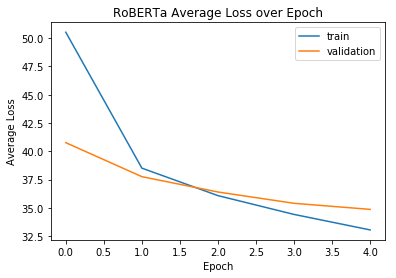

In [38]:
plt.plot(np.arange(5), train_loss_list_roberta, label = 'train')
plt.plot(np.arange(5), val_loss_list_roberta, label = 'validation')
plt.legend()
plt.title('RoBERTa Average Loss over Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.savefig('loss_RoBERTa.jpg')

In [ ]:
torch.save(model_roberta, 'model_roberta.pt')

In [ ]:
# model_roberta = torch.load('model_roberta.pt').to(device)

In [ ]:
test_label = []
test_logits = []
test_prediction = []

model_roberta.eval()
with torch.no_grad():
    for i, (input_ids_first, attention_masks_first, input_ids_second,
            attention_masks_second, labels) in enumerate(test_loader_roberta):

        input_ids_first = input_ids_first.to(device)
        attention_masks_first = attention_masks_first.to(device)
        input_ids_second = input_ids_second.to(device)
        attention_masks_second = attention_masks_second.to(device)
        labels = labels.to(device).float()

        logits = model_roberta(input_ids_first, attention_masks_first, input_ids_second, attention_masks_second)
        sigmoid_logits = torch.sigmoid(logits)
        prediction = torch.where(sigmoid_logits > 0.5, torch.tensor(1).to(device), torch.tensor(0).to(device))
        
        test_label.extend(labels.tolist())
        test_logits.extend(logits.tolist())
        test_prediction.extend(prediction.tolist())

In [ ]:
test_label_array = np.array(test_label)
test_logits_array = np.array(test_logits)
test_prediction_array = np.array(test_prediction)

In [ ]:
# Show precision and recall (at 10 and at 5)

from sklearn.metrics import precision_score, recall_score

In [ ]:
# At 10

label_at_10 = []
prediction_at_10 = []

top_10 = test_logits_array.argsort(axis = 1)[:,-10:]
for row,top in enumerate(top_10):
    test_label_top = test_label_array[row][top]
    test_prediction_top = test_prediction_array[row][top]

    label_at_10.extend(test_label_top)
    prediction_at_10.extend(test_prediction_top)
    

In [ ]:
precision_at_10 = precision_score(label_at_10, prediction_at_10)
recall_at_10 = recall_score(label_at_10, prediction_at_10)

In [37]:
print(precision_at_10)
print(recall_at_10)

0.717003419334784
0.5349754151591056


In [ ]:
# At 5

label_at_5 = []
prediction_at_5 = []

top_5 = test_logits_array.argsort(axis = 1)[:,-5:]
for row,top in enumerate(top_5):
    test_label_top = test_label_array[row][top]
    test_prediction_top = test_prediction_array[row][top]

    label_at_5.extend(test_label_top)
    prediction_at_5.extend(test_prediction_top)

In [ ]:
precision_at_5 = precision_score(label_at_5, prediction_at_5)
recall_at_5 = recall_score(label_at_5, prediction_at_5)

In [36]:
print(precision_at_5)
print(recall_at_5)

0.7327940680822379
0.724009324009324
